In [131]:
import os
import sys
import math
import numpy as np
import scipy, pylab
import scipy.io.wavfile as wave

import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.fftpack import dct
from spectrograms import *
%matplotlib inline

In [141]:
audio_dir = 'audio'
sample_rate = 22050
num_filt = 64
silence_level_threshold_db = -40

# we'll work with N seconds chunks
chunk_duration = 3     
chunk_duration_samples = sample_rate * chunk_duration    

In [142]:
# read the wave files (ride the wave!)
filenames = os.listdir(audio_dir)
wave_files = [wave.read(os.path.join(audio_dir, name)) for name in filenames]
for i, data in enumerate(wave_files):
    wave_files[i] = normalize_wave(data[1])
    assert data[0], sample_rate

In [143]:
# chop the files
chunks = []
labels = []
for file_index in range(len(filenames)):
    wave_data = wave_files[file_index]
    wave_duration = wave_data.shape[0]/sample_rate
    num_chunks = int(wave_duration) // chunk_duration
    #print(num_chunks)
    for chunk_index in range(num_chunks):
        chunk = wave_data[ chunk_index * chunk_duration_samples : (chunk_index+1) * chunk_duration_samples]
        
        mx = max(chunk.min(), chunk.max(), key=abs)
        mx = abs(mx)
        #print("max", 20*math.log10(mx), mx)
        mx = 20*math.log10(mx)
        
        # filter out silence
        if mx > silence_level_threshold_db:
            chunks.append( chunk )
            labels.append( filenames[file_index] )    



In [144]:
spectrograms = np.stack([spectrogram(sample_rate, chunk, num_filt=num_filt) for chunk in chunks])
spectrograms.shape

(182, 63, 299)

In [145]:
mean = np.mean(spectrograms, axis=0)
std = np.std(spectrograms, axis=0)
print(mean.shape, std.shape)

(63, 299) (63, 299)


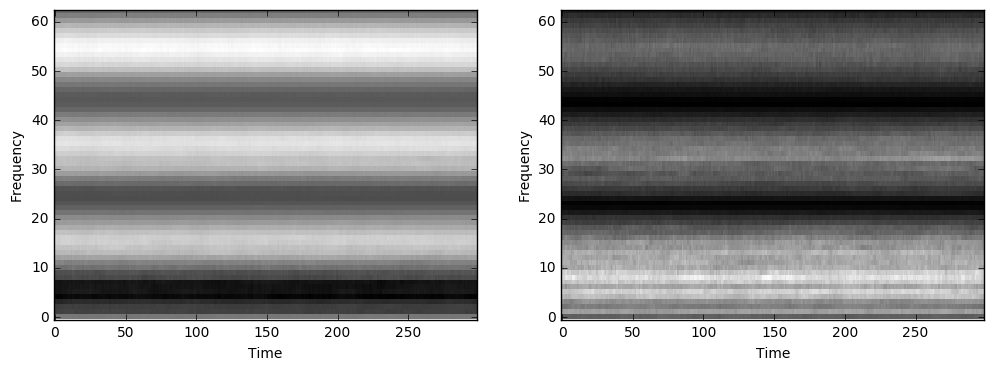

In [146]:
fig= pylab.figure( figsize=(12, 4), dpi=320)
a=fig.add_subplot(1,2,1)
pylab.imshow(mean, origin='lower', aspect='auto', interpolation='nearest', cmap='gray')
pylab.xlabel('Time')
pylab.ylabel('Frequency')

a=fig.add_subplot(1,2,2)
pylab.imshow(std, origin='lower', aspect='auto', interpolation='nearest', cmap='gray')
pylab.xlabel('Time')
pylab.ylabel('Frequency')
pylab.show()

In [147]:
# normalize dataset
data_norm = (spectrograms-mean)/std

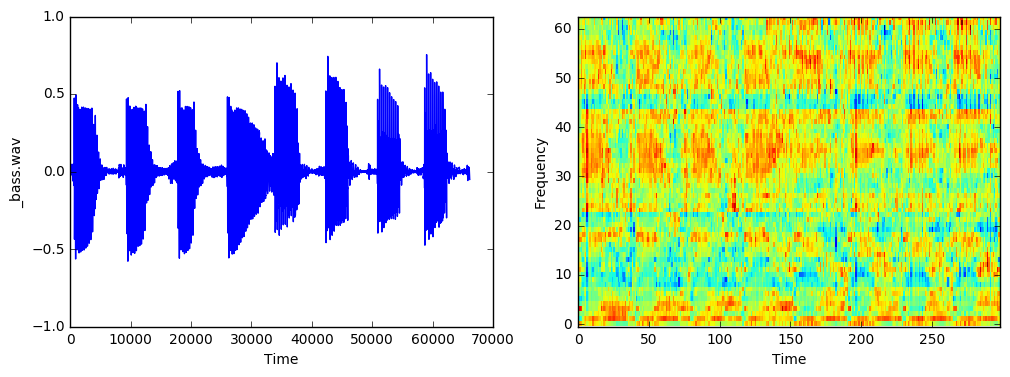

In [153]:
draw_index = 122


fig= pylab.figure( figsize=(12, 4), dpi=320,)
a=fig.add_subplot(1,2,1)
pylab.plot(chunks[draw_index])
pylab.xlabel('Time')
pylab.ylabel(labels[draw_index])
pylab.ylim([-1,1])

b=fig.add_subplot(1,2,2)
pylab.imshow(data_norm[draw_index], origin='lower', aspect='auto', interpolation='nearest') #, cmap='gray')
pylab.xlabel('Time')
pylab.ylabel('Frequency')
pylab.show()

In [140]:
sample_dir ='samples5'
if not os.path.exists(sample_dir):
    os.mkdir(sample_dir)
for i, w in enumerate(data_norm):
    fig= pylab.figure( figsize=(12, 4), dpi=320,)
    a=fig.add_subplot(1,2,1)
    pylab.plot(chunks[i])
    pylab.xlabel('Time')
    pylab.ylabel(labels[i])
    pylab.ylim([-1,1])

    b=fig.add_subplot(1,2,2)
    pylab.imshow(data_norm[i], origin='lower', aspect='auto', interpolation='nearest')#, cmap='gray')
    pylab.xlabel('Time')
    pylab.ylabel('Frequency')
    
    pylab.savefig(sample_dir + "/___spectr_" + str(i))
    fig.clear()

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
